In [6]:
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

from scipy.stats import ttest_ind
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import norm
import math

warnings.filterwarnings('ignore')
%matplotlib inline

# color palette
palette1 = "#007BFF"
palette2 = "#3ABFC2"
palette3 = "#E1C081"
palette4 = "#E17A57"
palette5 = "#D92D3F"

# load processed results
df = pd.read_csv("data/results/results_processed.csv")

In [8]:
df.head(3)

,PROLIFIC_PID,order,initial_rating,second_rating,knowledge,page_1_time,page_2_time,stimulus_ID,explanation_type,RecordedDate,Duration (in seconds),Comments,trust,NFC,CRT,condition,stimulation,ground_truth,topic,logical_validity
0,6108e03508bd5499cf3c2a71,1,2.3,1.0,2.5,23.30,27.030,1022.0,Honest,2022-12-02 09:13:52,736,Trust AI,3.333333,2.777778,0.000000,flag,trivia,False,The body's ability to self-heal,VALID
1,5f78ce64cb5f144a98a4fa38,1,4.0,5.0,1.0,8.03,9.871,524.0,Honest,2022-12-02 09:15:10,713,NaN,4.500000,3.166667,0.333333,flag,news,True,Biden's policies towards Iran,INVALID
2,6046a861fd56950eb9e314ea,1,4.1,4.1,1.1,16.80,15.842,1038.0,Deceptive,2022-12-02 09:18:10,942,"I really didn’t have a process per se, rather ...",3.500000,3.111111,0.000000,flag+explanation,trivia,False,Scientific names of wolves,VALID


In [9]:
# creating dummy variables aka binary features
df["trivia"] = df.stimulation=="trivia"
df["false_statement"] = (df.ground_truth==True).astype(int)
df["explanation"] = (df.condition=="flag+explanation").astype(int)
df["deceptive_feedback"] = (df.explanation_type=="Deceptive").astype(int)


df["deceptive_feedback_x_explanation"] = df["deceptive_feedback"]*df["explanation"]
df["deceptive_feedback_x_false_statement"] = df["deceptive_feedback"]*df["false_statement"]
df["deceptive_feedback_x_fs_x_explanation"] = df["deceptive_feedback"]*df["explanation"]*df["false_statement"]
df["explanation_x_false_statement"] = df["explanation"]*df["false_statement"]

df["rating_delta"] = df.second_rating - df.initial_rating

In [10]:
# double checking that the dta looks balanced, all good
df.groupby(["trivia","false_statement","explanation","deceptive_feedback"])["PROLIFIC_PID"].nunique()

trivia  false_statement  explanation  deceptive_feedback
False   0                0            0                     288
                                      1                     288
                         1            0                     300
                                      1                     300
        1                0            0                     289
                                      1                     289
                         1            0                     300
                                      1                     300
True    0                0            0                     299
                                      1                     299
                         1            0                     311
                                      1                     311
        1                0            0                     297
                                      1                     299
                         1            0        

In [16]:
x = []
for stimuli in [0,1]:
    for dv in ["initial_rating","second_rating","rating_delta"]:
        i = df[df.trivia==stimuli]
        res = sm.OLS(i[dv], 
                      sm.add_constant(i[[
                          'false_statement',
                          'explanation',
                          "explanation_x_false_statement",
                          'deceptive_feedback',
                          'deceptive_feedback_x_false_statement',
                          "deceptive_feedback_x_explanation",
                          "deceptive_feedback_x_fs_x_explanation",
                          "CRT",
                          #"NFC",
                          "trust",
                          "knowledge"
                      ]]), 
                      M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
        x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],x[4],x[5]])
stargazer.covariate_order([
                            'const',
                            'false_statement',
                            'explanation',
                            "explanation_x_false_statement",
                            'deceptive_feedback',
                            'deceptive_feedback_x_false_statement',
                            "deceptive_feedback_x_explanation",
                            "deceptive_feedback_x_fs_x_explanation",
                            "CRT",
                            #"NFC",
                            "trust",
                            "knowledge"
                          ])
stargazer.custom_columns(['N – 1st Rating', 'N – 2nd Rating',"N – Rating Delta",
                         'T – 1st Rating', 'T – 2nd Rating',"T – Rating Delta"],
                         [1,1,1,1,1,1])
stargazer.rename_covariates({
                            'const':'Constant',
                            'false_statement': "False Statement",
                            'explanation':"GPT Explanation",
                            "explanation_x_false_statement": "GPT Explanation * False Statement",
                            'deceptive_feedback': "Deceptive Feedback",
                            'deceptive_feedback_x_false_statement': "Deceptive Feedback * False Statement",
                            "deceptive_feedback_x_explanation": "Deceptive GPT Explanation",
                            "deceptive_feedback_x_fs_x_explanation": "Deceptive GPT Explanation * False Statement",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)
stargazer.add_line('Number of Participants', [
    df[df.trivia==0].PROLIFIC_PID.nunique(),
    df[df.trivia==0].PROLIFIC_PID.nunique(),
    df[df.trivia==0].PROLIFIC_PID.nunique(),
    df[df.trivia==1].PROLIFIC_PID.nunique(),
    df[df.trivia==1].PROLIFIC_PID.nunique(),
    df[df.trivia==1].PROLIFIC_PID.nunique(),
    ])
stargazer.add_line('Number of Stimuli', [
    df[df.trivia==0].topic.nunique(),
    df[df.trivia==0].topic.nunique(),
    df[df.trivia==0].topic.nunique(),
    df[df.trivia==1].topic.nunique(),
    df[df.trivia==1].topic.nunique(),
    df[df.trivia==1].topic.nunique(),
    ])
HTML(stargazer.render_html())


In [17]:
df.columns

Index(['PROLIFIC_PID', 'order', 'initial_rating', 'second_rating', 'knowledge',
       'page_1_time', 'page_2_time', 'stimulus_ID', 'explanation_type',
       'RecordedDate', 'Duration (in seconds)', 'Comments', 'trust', 'NFC',
       'CRT', 'condition', 'stimulation', 'ground_truth', 'topic',
       'logical_validity', 'trivia', 'false_statement', 'explanation',
       'deceptive_feedback', 'deceptive_feedback_x_explanation',
       'deceptive_feedback_x_false_statement',
       'deceptive_feedback_x_fs_x_explanation',
       'explanation_x_false_statement', 'rating_delta'],
      dtype='object')

In [18]:
# double checking that the dta looks balanced, all good
bb = df.groupby(["trivia","false_statement","explanation","deceptive_feedback","stimulus_ID"]).initial_rating.mean().reset_index()
aa = df.groupby(["trivia","false_statement","explanation","deceptive_feedback","stimulus_ID"]).second_rating.mean().reset_index()
aa

,trivia,false_statement,explanation,deceptive_feedback,stimulus_ID,second_rating
0,False,0,0,0,51.0,1.844915
1,False,0,0,0,57.0,1.797087
2,False,0,0,0,77.0,1.379412
3,False,0,0,0,97.0,1.137634
4,False,0,0,0,528.0,1.354945
...,...,...,...,...,...,...
211,True,1,1,1,1031.0,2.010687
212,True,1,1,1,1042.0,1.627027
213,True,1,1,1,1043.0,3.031667
214,True,1,1,1,1051.0,2.962698


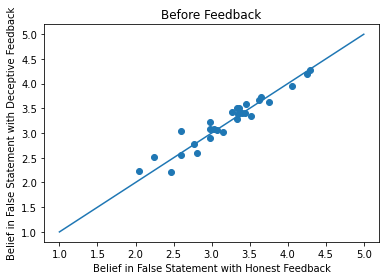

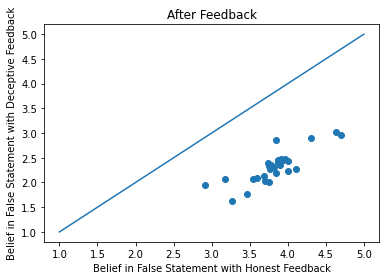

In [19]:
# Visual showing feedback (1) influences updating (2) people believe fake news/trivia less when given honest explanation and people believe fake news/trivia more when given deceptive explanation

plt.plot([1,2,3,4,5],[1,2,3,4,5])
plt.scatter(bb[(bb.false_statement==1) & (bb.explanation==1) & (bb.deceptive_feedback==0)]["initial_rating"],
            bb[(bb.false_statement==1) & (bb.explanation==1) & (bb.deceptive_feedback==1)]["initial_rating"])
plt.xlabel("Belief in False Statement with Honest Feedback")
plt.ylabel("Belief in False Statement with Deceptive Feedback")
plt.title("Before Feedback")
plt.show()
plt.plot([1,2,3,4,5],[1,2,3,4,5])
plt.scatter(aa[(aa.false_statement==1) & (aa.explanation==1) & (aa.deceptive_feedback==0)]["second_rating"],
            aa[(aa.false_statement==1) & (aa.explanation==1) & (aa.deceptive_feedback==1)]["second_rating"])
plt.xlabel("Belief in False Statement with Honest Feedback")
plt.ylabel("Belief in False Statement with Deceptive Feedback")
plt.title("After Feedback")
plt.show()